In [30]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

Tlist = [1.0]
from matplotlib.pyplot import cm
clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}

/tmp/ipykernel_714541/1561577914.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]


In [31]:
def read_kernel_33(dirname):
    filename = os.path.join(dirname, "s0-Sk-33-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s0CC,covs0CC = tuple([float(x) for x in fp.readline().split()[1:]])
    return s0CC, covs0CC

def read_kernel_23(dirname):
    filename = os.path.join(dirname, "s0-Sk-23-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s0CC,covs0CC = tuple([float(x) for x in fp.readline().split()[1:]])
    return s0CC, covs0CC

def read_kernel_22(dirname):
    filename = os.path.join(dirname, "s0-Sk-22-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s0CC,covs0CC = tuple([float(x) for x in fp.readline().split()[1:]])
    return s0CC, covs0CC

In [32]:
def read_lammpstrj(filedesc):
    # three comment lines
    for i in range(3): comment = filedesc.readline()
    # number of atoms
    natoms = int(filedesc.readline())

    # 1 comment line
    comment = filedesc.readline()
    # assume orthorombic cell
    cell = np.zeros(3,float)
    for i in range(3):
        # [cellmin, cellmax] = filedesc.readline().split()
        linec = filedesc.readline().split()
        cellmin = linec[0]
        cellmax = linec[1]
        cell[i] = float(cellmax) - float(cellmin)

    # 1 comment line
    comment = filedesc.readline()
    names = np.zeros(natoms,'U2')
    q = np.zeros((natoms,3),float)
    sq = np.zeros((natoms,3),float)

    for i in range(natoms):
        line = filedesc.readline().split();
        names[i] = line[1] # atom type
        q[i] = line[2:5] # wrapped atomic coordinates
        sq[i,0] = float(q[i,0])/cell[0] # scaled atomic coordinates
        sq[i,1] = float(q[i,1])/cell[1] # scaled atomic coordinates
        sq[i,2] = float(q[i,2])/cell[2] # scaled atomic coordinates
    return [cell, names, sq]

In [33]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

In [34]:
def cofactor(B):
    return (np.linalg.inv(B)).T * np.linalg.det(B)


In [35]:
def fillDmat(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = np.eye(rank)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

def fillDmat_(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = torch.eye(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

In [36]:
def fillapproxGmat(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-np.eye(rank,rank)/0.04
    return Gmat

def fillapproxGmat_(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-torch.eye(rank,rank).to(torch.float64)/0.04
    return Gmat

In [37]:
def KBI_mu(x_, Smat_, elem=0):
    rank = x_.shape[0]
    Smat_ = Smat_.reshape(rank, rank)

    # print("Approximate Gmat = ", approx_Gmat[0,0], approx_Gmat[1,1], approx_Gmat[0,1], approx_Gmat[1,0])
    # Smat_ = torch.from_numpy(Smat).requires_grad_()
    
    # Gmat = fillGmat(c, Smat)
    # Bmat = fillBmat(c, Gmat)
    # Dmat = fillDmat(x,Smat)
    Dmat_ = fillDmat_(x_,Smat_)
    # tiDmat = np.linalg.inv(Dmat).T
    tiDmat_ = torch.linalg.inv(Dmat_).T
    # Kai_NPT = np.zeros([rank,rank])
    Kai_NPT_ = torch.zeros([rank,rank], dtype=torch.float64)
    # x_ = torch.from_numpy(x).requires_grad_()
    for i in range(rank):
        for j in range(rank):
            s1 = 0.0
            s2 = 0.0
            s3 = 0.0
            for k in range(rank):
                s1 += tiDmat_[k][i]
                s2 += tiDmat_[k][j]
                for h in range(rank):
                    s3 += x_[h]*tiDmat_[k][h]
            Kai_NPT_[i][j] = tiDmat_[i][j]/x_[i] - s1*s2/s3
    print("Kai_NPT_N*V  = ",Kai_NPT_)
    Kai_NPT_lnx_ = torch.zeros(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i==j: 
                Kai_NPT_lnx_[i] += Kai_NPT_[i][i]*x_[i]
            else:
                Kai_NPT_lnx_[i] -= Kai_NPT_[i][j]*x_[i]
    # print("Kai_NPT_lnx = ", Kai_NPT_lnx_)
    
    Kai_NPT_00_a = 1./(x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1])  
    # print("!!!!!! checking:: ", (x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1]), Kai_NPT_00_a) 
    assert math.isclose(Kai_NPT_lnx_[0].detach().numpy(), Kai_NPT_00_a.detach().numpy(), abs_tol =  1e-4), print(Kai_NPT_lnx_[0].detach().numpy(), Kai_NPT_00_a.detach().numpy())
    return Kai_NPT_lnx_[elem]

In [38]:
frac_1 = 0.0
frac_2 = np.arange(0.1, 1.00, 0.05)
num_Vlist=[(0, frac_2[i]) for i in range(len(frac_2))]
print(num_Vlist)


[(0, 0.1), (0, 0.15000000000000002), (0, 0.20000000000000004), (0, 0.25000000000000006), (0, 0.30000000000000004), (0, 0.3500000000000001), (0, 0.40000000000000013), (0, 0.45000000000000007), (0, 0.5000000000000001), (0, 0.5500000000000002), (0, 0.6000000000000002), (0, 0.6500000000000001), (0, 0.7000000000000002), (0, 0.7500000000000002), (0, 0.8000000000000002), (0, 0.8500000000000002), (0, 0.9000000000000002), (0, 0.9500000000000003)]


In [39]:
Kai_NPT_lnx_list = []
Kai_NPT_lnx1_list = []
std_Kai_NPT_lnx_list = []
# order2_std_Kai_NPT_lnx_list = []
s0CC_list = []
s0HfC_list = []
s0HfHf_list = []
xlist = []
for idx_T, T in enumerate(Tlist):
    Kai_NPT_lnx_list.append([])
    Kai_NPT_lnx1_list.append([])
    std_Kai_NPT_lnx_list.append([])
    # order2_std_Kai_NPT_lnx_list.append([])
    s0CC_list.append([])
    s0HfC_list.append([])
    s0HfHf_list.append([])
    for idx_num_V, num_V in enumerate(num_Vlist):
        dirname = "A%.2fB%.2f/"%(num_Vlist[idx_num_V][0], num_Vlist[idx_num_V][1])
        s0CC, cov_s0CC = read_kernel_22(dirname)
        s0HfC, cov_s0HfC = read_kernel_23(dirname)
        s0HfHf, cov_s0HfHf = read_kernel_33(dirname)
        s0CC_list[-1].append(s0CC)
        s0HfC_list[-1].append(s0HfC)
        s0HfHf_list[-1].append(s0HfHf)

        x = (num_Vlist[idx_num_V][1], 1-num_Vlist[idx_num_V][1])
        print("Mole fraction of atoms in the system =",x)
        xlist.append(x[0])

        Smat = np.array([[s0CC, s0HfC], [s0HfC, s0HfHf]])

        std_Smat = np.sqrt(np.array([cov_s0CC, cov_s0HfC, cov_s0HfC, cov_s0HfHf]))
        # print("   std_Smat = ", std_Smat)
        varmat_Smat = np.outer(std_Smat, std_Smat)
        # print("varmat_Smat = ")
        # print(varmat_Smat)

        Smat_ = torch.from_numpy(Smat.reshape(-1)).to(dtype=torch.float64).requires_grad_()
        print("            Smat = ")
        print(Smat_.detach().numpy())
        x_ = torch.tensor(x).to(torch.float64).requires_grad_(False)
        
        Kai_NPT_lnx_0 = KBI_mu(x_, Smat_, 0)
        Kai_NPT_lnx_1 = KBI_mu(x_, Smat_, 1)
        print("Kai_NPT_lnx = ", Kai_NPT_lnx_0)
        jac = jacobian(KBI_mu, (x_, Smat_.reshape(-1)))[1]

        varmat_Smat_ = torch.from_numpy(varmat_Smat)
        varmat_KaiNPT_lnx = torch.matmul(torch.matmul(jac, varmat_Smat_), jac.T)
        
        std_KaiNPT_lnx = torch.sqrt(varmat_KaiNPT_lnx)
        Kai_NPT_lnx_list[-1].append(Kai_NPT_lnx_0.detach().numpy())
        Kai_NPT_lnx1_list[-1].append(Kai_NPT_lnx_1.detach().numpy())
        std_Kai_NPT_lnx_list[-1].append(std_KaiNPT_lnx.detach().numpy())
        print("\n")
        

Mole fraction of atoms in the system = (0.1, 0.9)
            Smat = 
[ 0.89573546 -0.27987339 -0.27987339  0.11245056]
Kai_NPT_N*V  =  tensor([[ 9.1340, -1.0149],
        [-1.0149,  0.1128]], dtype=torch.float64, grad_fn=<CopySlices>)
Kai_NPT_N*V  =  tensor([[ 9.1340, -1.0149],
        [-1.0149,  0.1128]], dtype=torch.float64, grad_fn=<CopySlices>)
Kai_NPT_lnx =  tensor(1.0149, dtype=torch.float64, grad_fn=<SelectBackward0>)
Kai_NPT_N*V  =  tensor([[ 9.1340, -1.0149],
        [-1.0149,  0.1128]], dtype=torch.float64, grad_fn=<CopySlices>)


Mole fraction of atoms in the system = (0.15000000000000002, 0.85)
            Smat = 
[ 0.84446903 -0.3325448  -0.3325448   0.15630814]
Kai_NPT_N*V  =  tensor([[ 5.7898, -1.0217],
        [-1.0217,  0.1803]], dtype=torch.float64, grad_fn=<CopySlices>)
Kai_NPT_N*V  =  tensor([[ 5.7898, -1.0217],
        [-1.0217,  0.1803]], dtype=torch.float64, grad_fn=<CopySlices>)
Kai_NPT_lnx =  tensor(1.0217, dtype=torch.float64, grad_fn=<SelectBackward0>)
Kai_N

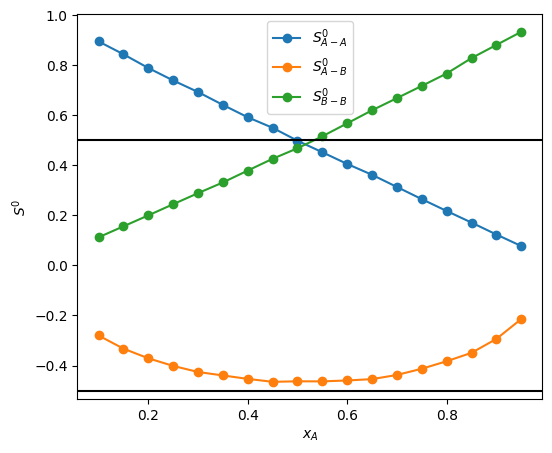

In [40]:
plt.rcParams["figure.figsize"] = (6,5)

plt.plot(xlist, s0CC_list[0], marker="o", label="$S^0_{B-B}$")
plt.plot(xlist, s0HfC_list[0], marker="o", label="$S^0_{B-C}$")
plt.plot(xlist, s0HfHf_list[0], marker="o", label="$S^0_{C-C}$")
plt.axhline(0.5, c="k")
plt.axhline(-0.5, c="k")
plt.xlabel("$x_A$")
plt.ylabel("$S^0$")
plt.legend()

In [41]:
Kai_NPT_lnx_list[0] = np.array(Kai_NPT_lnx_list[0])
Kai_NPT_lnx1_list[0] = np.array(Kai_NPT_lnx1_list[0])
print(Kai_NPT_lnx_list[0].shape)
'''
import dpdata

totalatom = 23328
c_A_list = []
c_B_list = []
N_A_list = []
N_B_list = []
Tlist = [1.]
Volume_list = []
for idx_T, T in enumerate(Tlist):
    c_A_list.append([])
    c_B_list.append([])
    Volume_list.append([])
    for idx_num_V, num_V in enumerate(num_Vlist):
        num_V1 = num_V[0]
        dirname = "binary/frac%.2f/"%(num_V1)
        filename = os.path.join(dirname, "thermo-lammps.dat")
        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]
        Volume = np.mean(Volume_data)
        Volume_list[-1].append(Volume)
        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")
        N_A_list.append(conf["atom_numbs"][0])
        N_B_list.append(conf["atom_numbs"][1])
        c_A = conf["atom_numbs"][0]/Volume
        c_A_list[-1].append(c_A)
        c_B = conf["atom_numbs"][1]/Volume
        c_B_list[-1].append(c_B)

        
        print(int(np.ceil(totalatom*num_V1)), conf["atom_numbs"][0])
        # assert int(np.ceil(totalatom*num_V1)) == conf["atom_numbs"][0]
        # assert int(totalatom-np.ceil(totalatom*num_V1)) == conf["atom_numbs"][1]
c_A_list = np.array(c_A_list)
c_B_list = np.array(c_B_list)
Volume_list = np.array(Volume_list)
N_A_list = np.array(N_A_list)
N_B_list = np.array(N_B_list)

print(c_A_list)
print(c_B_list)
print(totalatom)
assert np.allclose(c_A_list+c_B_list, totalatom/Volume_list)
'''

(18,)


'\nimport dpdata\n\ntotalatom = 23328\nc_A_list = []\nc_B_list = []\nN_A_list = []\nN_B_list = []\nTlist = [1.]\nVolume_list = []\nfor idx_T, T in enumerate(Tlist):\n    c_A_list.append([])\n    c_B_list.append([])\n    Volume_list.append([])\n    for idx_num_V, num_V in enumerate(num_Vlist):\n        num_V1 = num_V[0]\n        dirname = "binary/frac%.2f/"%(num_V1)\n        filename = os.path.join(dirname, "thermo-lammps.dat")\n        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]\n        Volume = np.mean(Volume_data)\n        Volume_list[-1].append(Volume)\n        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")\n        N_A_list.append(conf["atom_numbs"][0])\n        N_B_list.append(conf["atom_numbs"][1])\n        c_A = conf["atom_numbs"][0]/Volume\n        c_A_list[-1].append(c_A)\n        c_B = conf["atom_numbs"][1]/Volume\n        c_B_list[-1].append(c_B)\n\n        \n        print(int(np.ceil(totalatom*num_V1)), conf["atom_numbs"][0])\n        # as

In [42]:
x = np.array(xlist)
lnx = np.log(x).reshape(-1,1)
# lnc = np.log(c_A_list).reshape(-1,1)
x1 = 1-np.array(xlist)
lnx1 = np.log(x1).reshape(-1,1)
# lnc1 = np.log(c_B_list).reshape(-1,1)
# plt.plot(x, Volume_list[0])


In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.integrate import quad
# kernel = 1.0 * RBF(length_scale=0.005, length_scale_bounds="fixed")
kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp = GaussianProcessRegressor(kernel=kernel)

gp.fit(lnx.reshape(-1,1), Kai_NPT_lnx_list[0].reshape(-1,1))
y_gp, std_y_gp = gp.predict(lnx.reshape(-1,1), return_std=True)



kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp1 = GaussianProcessRegressor(kernel=kernel)
gp1.fit(lnx1.reshape(-1,1), Kai_NPT_lnx1_list[0].reshape(-1,1))
y_gp1, std_y_gp1 = gp1.predict(lnx1.reshape(-1,1), return_std=True)

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


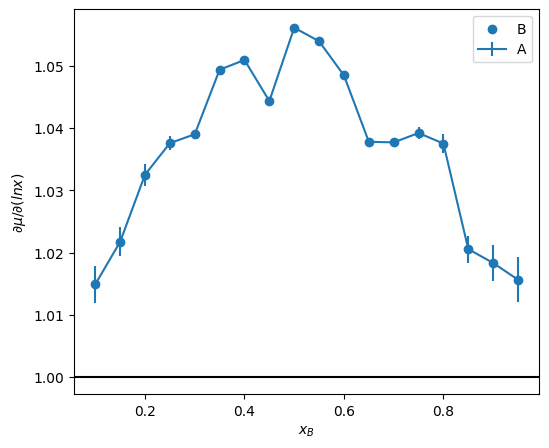

In [44]:
plt.rcParams["figure.figsize"] = (6,5)

# plt.scatter(x, Kai_NPT_lnx_list[0], marker="o", label="A")
# plt.scatter(x, y_gp, marker="*", label="A")
# plt.fill_between(x, y_gp+std_y_gp, y_gp-std_y_gp, label="A")
plt.errorbar(x, Kai_NPT_lnx_list[0], std_Kai_NPT_lnx_list[0], label="A")
plt.scatter(1-x1, Kai_NPT_lnx1_list[0], marker="o", label="B")
# plt.scatter(1-x1, y_gp1, marker="x", label="B")

plt.xlabel("$x_B$")
plt.ylabel("$\partial \mu/\partial (lnx) $")
plt.legend()
plt.axhline(1, c="k")


In [45]:
plt.rcParams["figure.figsize"] = (6,5)
from scipy.integrate import trapz
lnx1 = lnx1.reshape(-1)
lnx = lnx.reshape(-1)


integral_gp = np.cumsum([0]+[(y_gp[i]+y_gp[i+1])/2*(lnx[i+1]-lnx[i]) for i in range(len(lnx)-2)])
integral_gp1 = np.cumsum([0]+[(y_gp1[i]+y_gp1[i+1])/2*(lnx1[i+1]-lnx1[i]) for i in range(len(lnx1)-2)])
print("x-variable::")
print(x)
print(x1)
print("lnx-variable::")
print(lnx)
print(lnx1)
print("Integrand:: ")
print(y_gp)
print(y_gp1)
print("Integral cumsum")
print(integral_gp)
print(integral_gp1)

baseline = -np.array([lnx[i]-lnx[0] for i in range(len(lnx)-1)])
baseline1 = -np.array([lnx1[i]-lnx1[0] for i in range(len(lnx1)-1)])


print("baseline")
print(baseline)
print(baseline1)

print("excess")
print((integral_gp+baseline))
print((integral_gp1+baseline1))


x-variable::
[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]
[0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25
 0.2  0.15 0.1  0.05]
lnx-variable::
[-2.30258509 -1.89711998 -1.60943791 -1.38629436 -1.2039728  -1.04982212
 -0.91629073 -0.7985077  -0.69314718 -0.597837   -0.51082562 -0.43078292
 -0.35667494 -0.28768207 -0.22314355 -0.16251893 -0.10536052 -0.05129329]
[-0.10536052 -0.16251893 -0.22314355 -0.28768207 -0.35667494 -0.43078292
 -0.51082562 -0.597837   -0.69314718 -0.7985077  -0.91629073 -1.04982212
 -1.2039728  -1.38629436 -1.60943791 -1.89711998 -2.30258509 -2.99573227]
Integrand:: 
[1.01488739 1.02173289 1.03253074 1.03760164 1.0390364  1.04941873
 1.0509884  1.04437553 1.05617566 1.05399864 1.04850451 1.03781835
 1.03772666 1.03923146 1.03753602 1.02054955 1.01831791 1.01562731]
[1.01488739 1.02173289 1.03253074 1.03760164 1.0390364  1.04941873
 1.0509884  1.04437553 1.05617566 1.05399864 1.04850451 1.037818

In [46]:
# integral by MC

lnx = lnx.reshape(-1)
MCintegral_gp = [0]
MCintegral_gp_std = [0]
print(std_Kai_NPT_lnx_list)

for i in range(len(lnx)-2):
    min_lnx = lnx[0]
    max_lnx = lnx[i+1]
    area_lnx = (max_lnx-min_lnx)
    MC_x_samples = np.random.uniform(min_lnx, max_lnx, size=100*(i+1))
    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_samples -= 1.
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = max(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i+1])/np.sqrt(100*(i+1))
    print(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i+1],  MC_y_std*np.abs(area_lnx))
    MCintegral_gp.append(MC_y_average*(area_lnx))
    MCintegral_gp_std.append(MC_y_std*np.abs(area_lnx))

MCintegral_gp = np.array(MCintegral_gp)
MCintegral_gp_std = np.array(MCintegral_gp_std)



[[array(0.00294331), array(0.00236818), array(0.00178478), array(0.00111979), array(0.000731), array(0.00033909), array(6.56011387e-05), array(8.10458708e-05), array(0.00014509), array(0.00011012), array(1.29968085e-05), array(0.00023728), array(0.00056987), array(0.000985), array(0.0015285), array(0.00218651), array(0.00287665), array(0.00362382)]]
0.013687428130066367 0.002368180102706626 0.0005549774526480089
0.0 0.0017847767731192846 8.747709830618469e-05
0.0 0.0011197926150297288 5.923934738456347e-05
0.0 0.0007310006157738812 4.015431297565705e-05
0.0 0.0003390870543851175 1.8997441450989612e-05
0.0 6.56011386733295e-05 3.7127115512045095e-06
0.0 8.104587079648132e-05 4.607359046077099e-06
0.0 0.00014508720954005346 8.255784764614945e-06
0.0 0.00011012441442970504 6.257812846930446e-06
0.0 1.2996808465436723e-05 7.364044887965228e-07
0.0 0.00023727602243833447 1.3391137177112916e-05
0.0 0.0005698720952222637 3.201175995849998e-05
0.0 0.0009849976781043533 5.504497496250906e-05
0.

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Se

In [47]:

lnx1 = lnx1.reshape(-1)
MCintegral_gp1 = [0]
MCintegral_gp_std1 = [0]
print(x1)
print(lnx1)
print(x)
print(lnx)
for i in range(len(lnx1)-2):
    min_lnx = lnx1[0]
    max_lnx = lnx1[i+1]
    area_lnx = (max_lnx-min_lnx)
    MC_x_samples = np.random.uniform(min_lnx, max_lnx, size=100*(i+1))
    MC_y_samples, std_MC_y_samples = gp1.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_samples -= 1.
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(100*(i+1))
    MCintegral_gp1.append(MC_y_average*(area_lnx))
    MCintegral_gp_std1.append(MC_y_std*np.abs(area_lnx))

MCintegral_gp1 = np.array(MCintegral_gp1)
MCintegral_gp_std1 = np.array(MCintegral_gp_std1)

[0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25
 0.2  0.15 0.1  0.05]
[-0.10536052 -0.16251893 -0.22314355 -0.28768207 -0.35667494 -0.43078292
 -0.51082562 -0.597837   -0.69314718 -0.7985077  -0.91629073 -1.04982212
 -1.2039728  -1.38629436 -1.60943791 -1.89711998 -2.30258509 -2.99573227]
[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]
[-2.30258509 -1.89711998 -1.60943791 -1.38629436 -1.2039728  -1.04982212
 -0.91629073 -0.7985077  -0.69314718 -0.597837   -0.51082562 -0.43078292
 -0.35667494 -0.28768207 -0.22314355 -0.16251893 -0.10536052 -0.05129329]


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Se

In [48]:

lowerb_MCintegral_gp = MCintegral_gp-MCintegral_gp_std
upperb_MCintegral_gp = MCintegral_gp+MCintegral_gp_std
print(MCintegral_gp_std)


[0.00000000e+00 5.54977453e-04 8.74770983e-05 5.92393474e-05
 4.01543130e-05 1.89974415e-05 3.71271155e-06 4.60735905e-06
 8.25578476e-06 6.25781285e-06 7.36404489e-07 1.33911372e-05
 3.20117600e-05 5.50449750e-05 8.49467461e-05 1.20818581e-04
 1.58016247e-04]


[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]
[0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25
 0.2  0.15 0.1  0.05]


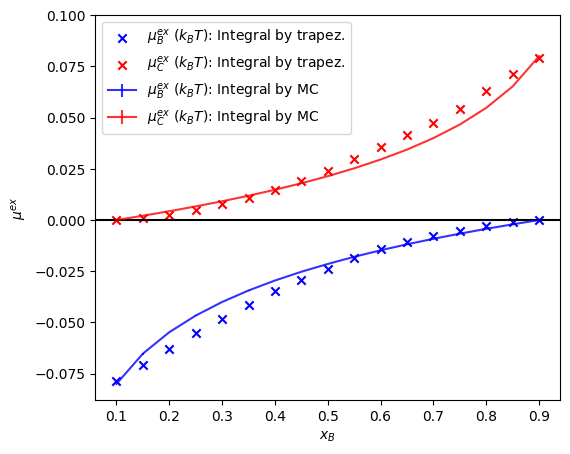

In [49]:
print(x)
print(x1)
plt.scatter(x[:-1], (integral_gp+baseline)-(integral_gp+baseline)[-1], label="$\mu^{ex}_B$ ($k_BT$): Integral by trapez.", c="blue", marker="x")
plt.errorbar(x[:-1], MCintegral_gp-MCintegral_gp[-1], MCintegral_gp_std, color="blue", alpha=0.8, label="$\mu^{ex}_B$ ($k_BT$): Integral by MC")
plt.scatter(x[:-1], (-(integral_gp1+baseline1)+(integral_gp1+baseline1)[0]), label="$\mu^{ex}_C$ ($k_BT$): Integral by trapez.", c="red", marker="x")
plt.errorbar(x[:-1], (-MCintegral_gp1+MCintegral_gp1[0]), (MCintegral_gp_std1), color="red", alpha=0.8, label="$\mu^{ex}_C$ ($k_BT$): Integral by MC")
# plt.fill_between(x[:-1], lowerb_MCintegral_gp, upperb_MCintegral_gp, color="blue", alpha=0.8)
plt.axhline(0, c="k")
plt.ylabel("$\mu^{ex}$")
plt.xlabel("$x_B$")
plt.ylim((None, 0.1))
plt.legend()

# plt.figure()
# plt.scatter(x[:-1], ((integral_gp1+baseline1)), label="$\mu^{ex}_B$ ($k_BT$): Integral by trapez.", c="red", marker="x")
# plt.errorbar(x[:-1], (MCintegral_gp1), (MCintegral_gp_std1), color="red", alpha=0.8, label="$\mu^{ex}_B$ ($k_BT$): Integral by MC")
# plt.ylim((-0.05, 0.05))

In [50]:
print("4040K to kJ/mol:", 4040./298.*2.074)
print("4040K to eV:", 4040./300.*0.0259)

4040K to kJ/mol: 28.117315436241608
4040K to eV: 0.3487866666666667
